In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df= pd.read_excel("R1G_R1V.xlsx")

slow and fast signal

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

monthly_ratio = df.resample('M', on='Date')['ratio'].mean()
monthly_ratio_pct_change = monthly_ratio.pct_change().dropna()


lookback_fast = 3
lookback_slow = 12

fast_signal = monthly_ratio_pct_change.rolling(window=lookback_fast).mean().dropna()
slow_signal = monthly_ratio_pct_change.rolling(window=lookback_slow).mean().dropna()

monthly_ratio.index = monthly_ratio.index.to_period('M')
fast_signal.index = fast_signal.index.to_period('M')
slow_signal.index = slow_signal.index.to_period('M')

# Now the indices of monthly_ratio, fast_signal, and slow_signal only contain year and month
monthly_ratio, fast_signal, slow_signal

monthly_ratio.to_frame()




,ratio
Date,
1991-01,0.994711
1991-02,1.014354
1991-03,1.031177
1991-04,1.048159
1991-05,1.042428
...,...
2023-08,1.245527
2023-09,1.262099
2023-10,1.291403


In [5]:
monthly_ratio_pct_change.head(5)

Date
1991-02-28    0.019747
1991-03-31    0.016586
1991-04-30    0.016469
1991-05-31   -0.005468
1991-06-30   -0.012955
Freq: M, Name: ratio, dtype: float64

In [6]:
common_length = min(len(fast_signal), len(slow_signal))
aligned_fast_signal = fast_signal[-common_length:]
aligned_slow_signal = slow_signal[-common_length:]

def classify_market_condition(slow, fast):
    if slow >= 0 and fast >= 0:
        return 'Bull'
    elif slow >= 0 and fast < 0:
        return 'Correction'
    elif slow < 0 and fast < 0:
        return 'Bear'
    elif slow < 0 and fast >= 0:
        return 'Rebound'
    else:
        return 'Undefined'
    
    
market_conditions = pd.DataFrame({
    'Slow Signal': aligned_slow_signal,
    'Fast Signal': aligned_fast_signal
}).apply(lambda row: classify_market_condition(row['Slow Signal'], row['Fast Signal']), axis=1)

market_conditions_df= market_conditions.to_frame()
market_conditions_df.reset_index(inplace=True)
market_conditions_df.head()

   

,Date,0
0,1992-01,Bull
1,1992-02,Bull
2,1992-03,Correction
3,1992-04,Correction
4,1992-05,Bear


In [7]:
merged_df = pd.DataFrame({
    'Ratio': monthly_ratio,
    'Fast Signal': aligned_fast_signal,
    'Slow Signal': aligned_slow_signal,
    'Market Condition': market_conditions
})

merged_df.tail(5)


,Ratio,Fast Signal,Slow Signal,Market Condition
Date,,,,
2023-08,1.245527,0.012905,0.006401,Bull
2023-09,1.262099,0.003069,0.009669,Bull
2023-10,1.291403,0.009883,0.013549,Bull
2023-11,1.329225,0.021937,0.019800,Bull
2023-12,1.315847,0.014147,0.019517,Bull


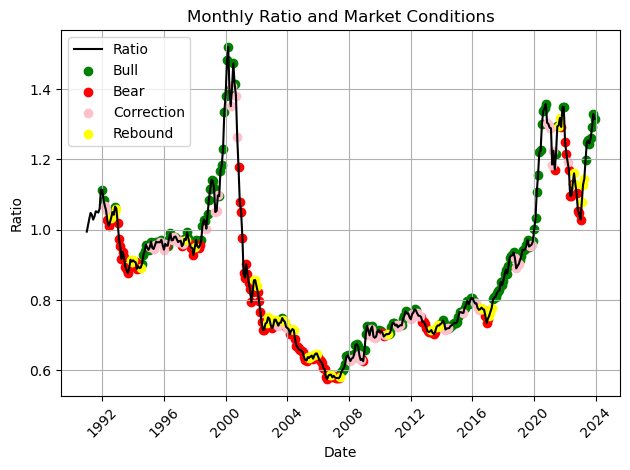

In [8]:
import matplotlib.pyplot as plt

merged_df.index = merged_df.index.to_timestamp()

plt.plot(merged_df.index, merged_df['Ratio'], color='black', label='Ratio')

# Prepare colors for the market conditions
market_conditions_colors = {'Bull': 'green', 'Bear': 'red', 'Correction': 'pink', 'Rebound': 'yellow'}

# Plot each market condition
for condition, color in market_conditions_colors.items():
    # Filter the data for the current condition
    condition_data = merged_df[merged_df['Market Condition'] == condition]
    # Plot the data
    plt.scatter(condition_data.index, condition_data['Ratio'], color=color, label=condition)

plt.title('Monthly Ratio and Market Conditions')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.tight_layout()  # Adjust layout to make room for the rotated date labels

plt.show()

hard to identify which is which, i should really ignore the correction and rebound 

In [9]:
df1= pd.read_excel("R1G_R1V.xlsx")

In [10]:
df1['Date'] = df['Date'].dt.strftime('%Y-%m')
monthly_avg = df1.groupby("Date").agg({"R1G value": "mean", "R1V value": "mean"}).reset_index()
monthly_avg['Date'] = pd.to_datetime(monthly_avg['Date']).dt.to_period('M')

merged_df = pd.merge(monthly_avg, market_conditions_df, on='Date')
merged_df.head(5)


,Date,R1G value,R1V value,0
0,1992-01,140.265455,125.987727,Bull
1,1992-02,138.233684,127.437368,Bull
2,1992-03,135.758182,126.999091,Correction
3,1992-04,134.451905,127.499048,Correction
4,1992-05,135.535000,131.949500,Bear


In [11]:
merged_df.to_csv("market_conditions.csv", index=False)

### baseline

In [12]:
# Initial investment details
initial_investment = 10000  # Total initial investment
investment_per_stock = initial_investment / 2  # Splitting investment equally

# Getting the initial and final prices for R1G and R1V stocks
initial_r1g_price = merged_df['R1G value'].iloc[0]
final_r1g_price = merged_df['R1G value'].iloc[-1]

initial_r1v_price = merged_df['R1V value'].iloc[0]
final_r1v_price = merged_df['R1V value'].iloc[-1]

# Calculating the amount of each stock bought initially
r1g_stocks_bought = investment_per_stock / initial_r1g_price
r1v_stocks_bought = investment_per_stock / initial_r1v_price

# Calculating the final value of the investment
final_r1g_value = r1g_stocks_bought * final_r1g_price
final_r1v_value = r1v_stocks_bought * final_r1v_price

final_investment_value = final_r1g_value + final_r1v_value

# Displaying the calculated final investment value
final_investment_value

202252.1111777841

##### Maximum Drawdown Baseline

In [13]:
initial_investment = 10000  # Total initial investment
investment_per_stock = initial_investment / 2  # Splitting investment equally
# Initial and final prices for R1G and R1V stocks
initial_r1g_price = merged_df['R1G value'].iloc[0]
final_r1g_price = merged_df['R1G value'].iloc[-1]

initial_r1v_price = merged_df['R1V value'].iloc[0]
final_r1v_price = merged_df['R1V value'].iloc[-1]

# Amount of each stock bought initially
r1g_stocks_bought = investment_per_stock / initial_r1g_price
r1v_stocks_bought = investment_per_stock / initial_r1v_price

# Calculating daily portfolio values
merged_df['Portfolio Value'] = (r1g_stocks_bought * merged_df['R1G value']) + (r1v_stocks_bought * merged_df['R1V value'])

# Running maximum of the portfolio value
merged_df['Max Portfolio Value'] = merged_df['Portfolio Value'].cummax()

# Drawdown calculation
merged_df['Drawdown'] = merged_df['Max Portfolio Value'] - merged_df['Portfolio Value']

# Maximum Drawdown (MDD)
mdd = merged_df['Drawdown'].max()

mdd

41290.49198668785

##### Sharpe Ratio
3 month T-Bill: 5%

In [18]:
def sharpe(returns,risk_free_rate):
    average_return = np.mean(returns)

    # Calculate the standard deviation of the portfolio's returns
    std_dev = np.std(returns)

    # Calculate the Sharpe Ratio
    sharpe_ratio = (average_return - risk_free_rate) / std_dev

    return sharpe_ratio


In [19]:
merged_df["periodic_return"] = merged_df["Portfolio Value"].shift(1)
merged_df["periodic_return"] = (merged_df["Portfolio Value"] / merged_df["periodic_return"]) - 1
merged_df["periodic_return"].fillna(0, inplace=True)

In [20]:
baseline_sharpe = sharpe(merged_df["periodic_return"],0.05)

-1.1364404303760336

### strategy #1. ignoring correction and rebound phase

In [23]:
# # Starting conditions
# initial_investment = 10000  # Total initial investment
# current_cash = initial_investment  # Total cash available for investment
# r1g_stocks = investment_per_stock / initial_r1g_price  # Initial amount of R1G stocks bought
# r1v_stocks = investment_per_stock / initial_r1v_price  # Initial amount of R1V stocks bought

# # Iterating through the dataset to apply the investment strategy
# for index, row in merged_df.iterrows():
#     market_condition = row[0]
#     current_r1g_price = row['R1G value']
#     current_r1v_price = row['R1V value']

#     if market_condition == 'Bull':
#         # Sell all R1V stocks and spend all money on R1G stock
#         current_cash = r1v_stocks * current_r1v_price  # Selling R1V stocks
#         r1v_stocks = 0  # No R1V stocks left after selling
#         r1g_stocks += current_cash / current_r1g_price  # Buying R1G stocks with available cash

#     elif market_condition == 'Bear':
#         # Sell all R1G stocks and spend all money on R1V stock
#         current_cash = r1g_stocks * current_r1g_price  # Selling R1G stocks
#         r1g_stocks = 0  # No R1G stocks left after selling
#         r1v_stocks += current_cash / current_r1v_price  # Buying R1V stocks with available cash

#     # If the market condition is 'Correction' or 'Rebound', do nothing

# # Calculating the final value of the investment after applying the strategy
# final_r1g_value = r1g_stocks * final_r1g_price
# final_r1v_value = r1v_stocks * final_r1v_price
# final_investment_value_strategy_1 = final_r1g_value + final_r1v_value

# # Displaying the calculated final investment value after applying the strategy
# final_investment_value_strategy_1

409820.4965480961

In [21]:
initial_investment = 10000  # Total initial investment
current_cash = initial_investment  # Total cash available for investment
r1g_stocks = investment_per_stock / initial_r1g_price  # Initial amount of R1G stocks bought
r1v_stocks = investment_per_stock / initial_r1v_price  # Initial amount of R1V stocks bought
portfolio_values = []
# Iterating through the dataset to apply the investment strategy
for index, row in merged_df.iterrows():
    market_condition = row[0]
    current_r1g_price = row['R1G value']
    current_r1v_price = row['R1V value']

    if market_condition == 'Bull':
        # Sell all R1V stocks and spend all money on R1G stock
        current_cash = r1v_stocks * current_r1v_price  # Selling R1V stocks
        r1v_stocks = 0  # No R1V stocks left after selling
        r1g_stocks += current_cash / current_r1g_price  # Buying R1G stocks with available cash

    elif market_condition == 'Bear':
        # Sell all R1G stocks and spend all money on R1V stock
        current_cash = r1g_stocks * current_r1g_price  # Selling R1G stocks
        r1g_stocks = 0  # No R1G stocks left after selling
        r1v_stocks += current_cash / current_r1v_price  # Buying R1V stocks with available cash

    portfolio_value = (r1g_stocks * current_r1g_price) + (r1v_stocks * current_r1v_price)
    portfolio_values.append(portfolio_value)


# Calculating the final value of the investment after applying the strategy
final_r1g_value = r1g_stocks * final_r1g_price
final_r1v_value = r1v_stocks * final_r1v_price
final_investment_value_strategy_1 = final_r1g_value + final_r1v_value

# Displaying the calculated final investment value after applying the strategy
final_investment_value_strategy_1

409820.4965480961

##### Maximum Drawdown Strategy 1

In [22]:
strategy_portfolio_df = pd.DataFrame(portfolio_values, columns=['Portfolio Value'])
strategy_portfolio_df['Max Portfolio Value'] = strategy_portfolio_df['Portfolio Value'].cummax()
strategy_portfolio_df['Drawdown'] = strategy_portfolio_df['Max Portfolio Value'] - strategy_portfolio_df['Portfolio Value']

In [23]:
s1_sharpe = strategy_portfolio_df['Drawdown'].max()

72309.56478899252

##### sharpe S1

In [24]:
strategy_portfolio_df["periodic_return"] = strategy_portfolio_df["Portfolio Value"].shift(1)
strategy_portfolio_df["periodic_return"] = (strategy_portfolio_df["Portfolio Value"] / strategy_portfolio_df["periodic_return"]) - 1
strategy_portfolio_df["periodic_return"].fillna(0, inplace=True)

In [25]:
sharpe(strategy_portfolio_df["periodic_return"],0.05)

-1.0617632506299766

### strategy #2: dynamic trend following strategy, turning point weighting 

In [33]:
monthly_ratio_pct_change

Date
1991-02-28    0.019747
1991-03-31    0.016586
1991-04-30    0.016469
1991-05-31   -0.005468
1991-06-30   -0.012955
                ...   
2023-08-31   -0.006875
2023-09-30    0.013305
2023-10-31    0.023219
2023-11-30    0.029287
2023-12-31   -0.010064
Freq: ME, Name: ratio, Length: 395, dtype: float64

In [29]:
return_df= monthly_ratio_pct_change.to_frame(name='return')
return_df.reset_index(inplace=True)
return_df['Date'] = return_df['Date'].dt.strftime('%Y-%m')
return_df['Date'] = pd.to_datetime(return_df['Date']).dt.to_period('M') 
dynamic_df = pd.merge(return_df, merged_df, on='Date')
dynamic_df.rename(columns={0: 'Market condition'}, inplace=True)
dynamic_df.head(5)

,Date,return,R1G value,R1V value,Market condition,Portfolio Value,Max Portfolio Value,Drawdown,periodic_return
0,1992-01,-0.000273,140.265455,125.987727,Bull,10000.000000,10000.000000,0.000000,0.000000
1,1992-02,-0.025701,138.233684,127.437368,Bull,9985.105147,10000.000000,14.894853,-0.001489
2,1992-03,-0.014588,135.758182,126.999091,Correction,9879.468007,10000.000000,120.531993,-0.010579
3,1992-04,-0.013197,134.451905,127.499048,Correction,9852.745031,10000.000000,147.254969,-0.002705
4,1992-05,-0.026263,135.535000,131.949500,Bear,10067.976254,10067.976254,0.000000,0.021845


In [30]:
# Initialize new columns with NaN values
dynamic_df['Return Correction'] = pd.NA
dynamic_df['Return Rebound'] = pd.NA

# Calculate 'Return Correction'
correction_mask = dynamic_df['Market condition'] == 'Correction'
dynamic_df.loc[correction_mask, 'Return Correction'] = dynamic_df.loc[correction_mask, 'return'].expanding().mean()

# Calculate 'Return Rebound'
rebound_mask = dynamic_df['Market condition'] == 'Rebound'
dynamic_df.loc[rebound_mask, 'Return Rebound'] = dynamic_df.loc[rebound_mask, 'return'].expanding().mean()

dynamic_df.head(5)




,Date,return,R1G value,R1V value,Market condition,Portfolio Value,Max Portfolio Value,Drawdown,periodic_return,Return Correction,Return Rebound
0,1992-01,-0.000273,140.265455,125.987727,Bull,10000.000000,10000.000000,0.000000,0.000000,<NA>,<NA>
1,1992-02,-0.025701,138.233684,127.437368,Bull,9985.105147,10000.000000,14.894853,-0.001489,<NA>,<NA>
2,1992-03,-0.014588,135.758182,126.999091,Correction,9879.468007,10000.000000,120.531993,-0.010579,-0.014588,<NA>
3,1992-04,-0.013197,134.451905,127.499048,Correction,9852.745031,10000.000000,147.254969,-0.002705,-0.013893,<NA>
4,1992-05,-0.026263,135.535000,131.949500,Bear,10067.976254,10067.976254,0.000000,0.021845,<NA>,<NA>


In [31]:
matching_entries = dynamic_df[dynamic_df['Market condition'] == 'Correction']
print(matching_entries)

        Date    return    R1G value    R1V value Market condition  \
2    1992-03 -0.014588   135.758182   126.999091       Correction   
3    1992-04 -0.013197   134.451905   127.499048       Correction   
37   1995-02  0.008395   164.607895   173.125263       Correction   
40   1995-05 -0.003373   178.565455   188.883182       Correction   
41   1995-06  0.010415   185.472654   194.155472       Correction   
..       ...       ...          ...          ...              ...   
348  2021-01 -0.008389  2437.227679  1889.074343       Correction   
349  2021-02 -0.001175  2502.092645  1941.934692       Correction   
350  2021-03 -0.080062  2409.066659  2032.056541       Correction   
351  2021-04  0.033260  2593.208698  2116.580824       Correction   
362  2022-03 -0.019198  2692.560990  2255.270936       Correction   

     Portfolio Value  Max Portfolio Value      Drawdown  periodic_return  \
2        9879.468007         10000.000000    120.531993        -0.010579   
3        9852.74503

In [32]:
dynamic_df.to_csv("dynamic.csv", index=False)

In [33]:
investment_per_stock

5000.0

In [34]:
initial_investment2 = 10000  # Total initial investment
current_cash2 = initial_investment2  # Total cash available for investment
r1g_stocks2 = investment_per_stock / initial_r1g_price  # Initial amount of R1G stocks bought
r1v_stocks2 = investment_per_stock / initial_r1v_price  # Initial amount of R1V stocks bought
alpha= 0.9



# Iterating through each row in the dataframe to apply the specified strategy
for index, row in dynamic_df.iterrows():
    market_condition = row['Market condition']
    r1g_price = row['R1G value']
    r1v_price = row['R1V value']
    
    if market_condition == 'Bull':
        # Buy all R1G and sell all R1V
        current_cash2= r1v_stocks2  * r1v_price
        r1v_stocks2 = 0  # Sell all R1V
        r1g_stocks2 += current_cash2  / r1g_price  # Buy R1G with all cash
        
    elif market_condition == 'Bear':
        current_cash2= r1g_stocks2 * r1g_price
        r1g_stocks2 = 0  # Sell all R1G
        r1v_stocks2 += current_cash2 / r1v_price  # Buy R1V with all cash
        
    elif market_condition == 'Correction':
        # Adjust holdings based on the return correction
        return_correction = row['Return Correction']
        current_cash2= r1v_stocks2* r1v_price + r1g_stocks2 * r1g_price
        r1g_stocks2=0
        r1v_stocks2=0
        if return_correction < 0:
            # 70% R1V and 30% R1G
            r1v_stocks2 += alpha * current_cash2 / r1v_price
            r1g_stocks2 += (1-alpha) * current_cash2 / r1g_price
        else:
            # 30% R1V and 70% R1G
            r1v_stocks2 += (1-alpha) * current_cash2 / r1v_price
            r1g_stocks2 = alpha * current_cash2 / r1g_price
            
    elif market_condition == 'Rebound':
        # Adjust holdings based on the return rebound
        return_rebound = row['Return Rebound']
        current_cash2= r1v_stocks2* r1v_price + r1g_stocks2 * r1g_price
        r1g_stocks2=0
        r1v_stocks2=0
        if return_rebound < 0:
            # 30% R1G and 70% R1V
            r1v_stocks2 = alpha * current_cash2 / r1v_price
            r1g_stocks2 = (1-alpha) * current_cash2 / r1g_price
            current_cash2=0
        else:
            # 70% R1G and 30% R1V
            r1v_stocks2 = (1-alpha) * current_cash2 / r1v_price
            r1g_stocks2 = alpha * current_cash2 / r1g_price
            current_cash2=0


# Calculate final value of investments
final_cash =  r1v_stocks2 * final_r1g_price + r1g_stocks2 * final_r1v_price

final_cash

332170.7273750701

##### MDD S2 new

In [35]:
initial_investment2 = 10000 
current_cash2 = initial_investment2  
investment_per_stock2 = initial_investment2 / 2  
r1g_stocks2 = investment_per_stock / initial_r1g_price  
r1v_stocks2 = investment_per_stock / initial_r1v_price  
alpha = 0.9  


portfolio_values2 = [] 

for index, row in dynamic_df.iterrows():
    market_condition = row['Market condition']
    r1g_price = row['R1G value']
    r1v_price = row['R1V value']
    
    if market_condition == 'Bull':
        current_cash2= r1v_stocks2  * r1v_price
        r1v_stocks2 = 0
        r1g_stocks2 += current_cash2  / r1g_price
        
    elif market_condition == 'Bear':
        current_cash2= r1g_stocks2 * r1g_price
        r1g_stocks2 = 0
        r1v_stocks2 += current_cash2 / r1v_price
        
    elif market_condition == 'Correction':
        return_correction = row['Return Correction']
        current_cash2= r1v_stocks2 * r1v_price + r1g_stocks2 * r1g_price
        r1g_stocks2 = 0
        r1v_stocks2 = 0
        r1v_stocks2 += alpha * current_cash2 / r1v_price
        r1g_stocks2 += (1-alpha) * current_cash2 / r1g_price
            
    elif market_condition == 'Rebound':
        return_rebound = row['Return Rebound']
        current_cash2= r1v_stocks2 * r1v_price + r1g_stocks2 * r1g_price
        r1g_stocks2 = 0
        r1v_stocks2 = 0
        r1v_stocks2 = (1-alpha) * current_cash2 / r1v_price
        r1g_stocks2 = alpha * current_cash2 / r1g_price


    portfolio_value2 = (r1g_stocks2 * r1g_price) + (r1v_stocks2 * r1v_price)
    portfolio_values2.append(portfolio_value2)


strategy_portfolio_df2 = pd.DataFrame(portfolio_values2, columns=['Portfolio Value'])
strategy_portfolio_df2['Max Portfolio Value'] = strategy_portfolio_df2['Portfolio Value'].cummax()
strategy_portfolio_df2['Drawdown'] = strategy_portfolio_df2['Max Portfolio Value'] - strategy_portfolio_df2['Portfolio Value']


mdd_strategy2 = strategy_portfolio_df2['Drawdown'].max()
final_investment_value_strategy2 = strategy_portfolio_df2['Portfolio Value'].iloc[-1]

final_investment_value_strategy2, mdd_strategy2

(437066.9369903773, 88352.39647144172)

In [36]:
strategy_portfolio_df2["periodic_return"] = strategy_portfolio_df2["Portfolio Value"].shift(1)
strategy_portfolio_df2["periodic_return"] = (strategy_portfolio_df2["Portfolio Value"] / strategy_portfolio_df2["periodic_return"]) - 1
strategy_portfolio_df2["periodic_return"].fillna(0, inplace=True)
s2_sharpe = sharpe(strategy_portfolio_df2["periodic_return"],0.05)

In [37]:
s2_sharpe

-1.100144477754819